<a href="https://colab.research.google.com/github/AndriiUriadov/DysonLineParamsExtractorCNN/blob/one-head/DysonianLineCNN_multihead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Перевірка наявності GPU та обсягу оперативної памʼяті середовища виконання.

Перед початком роботи необхідно перевірити наявність підключеного GPU та обсяг доступної оперативної памʼяті.
Це дозволяє оцінити, чи середовище підходить для навчання моделі, оскільки GPU значно прискорює навчання, а обмежена RAM може призвести до збоїв при обробці великих обсягів даних.

In [1]:
# Перевірка наявності GPU
import subprocess

try:
    gpu_info = subprocess.check_output(['nvidia-smi'], stderr=subprocess.STDOUT).decode()
    print('✅ Виявлено GPU. Інформація:')
    print(gpu_info)
except subprocess.CalledProcessError as e:
    print('❌ Команда nvidia-smi виконалась з помилкою:')
    print(e.output.decode())
    print('⚠️ Ймовірно, GPU відсутній або не підтримується.')
except FileNotFoundError:
    print('❌ Команда nvidia-smi не знайдена. GPU, ймовірно, відсутній.')

# Перевірка оперативної пам’яті середовища виконання
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print('\n Доступна оперативна пам’ять: {:.1f} ГБ'.format(ram_gb))

if ram_gb < 20:
    print('⚠️ Використовується середовище з обмеженою RAM.')
else:
    print('✅ Використовується середовище з великою RAM (high-RAM runtime).')


❌ Команда nvidia-smi не знайдена. GPU, ймовірно, відсутній.

 Доступна оперативна пам’ять: 13.6 ГБ
⚠️ Використовується середовище з обмеженою RAM.


# Створення нейронної мережі для передбачення параметрів лінії Дайсона

1. Завантаження даних для навчання.
2. Нормалізація даних для навчання та розділення на датасети: тренування, валідації, тестування.
3. Створення моделі.
4. Навчання моделі.
5. Оцінка моделі на тестових даних та денормалізація результатів.
6. Збереження моделі.

# 1. Завантаження даних для навчання в середовище виконання

In [ ]:
import gdown
import numpy as np

# Google Drive file IDs
file_id_X = '1kOeVd4d1PZfPhfoVIPKXSUScV0tfiRcD'
file_id_y = '1LKHYyAnb3Ls1qKbxlXOvc6mUY_fMSiAk'

# Створюємо прямі посилання
url_X = f'https://drive.google.com/uc?id={file_id_X}'
url_y = f'https://drive.google.com/uc?id={file_id_y}'

# Завантажуємо файли
gdown.download(url_X, 'X_dyson.npy', quiet=False)
gdown.download(url_y, 'y_dyson.npy', quiet=False)

# Завантажуємо у змінні
X = np.load('X_dyson.npy')
y = np.load('y_dyson.npy')

print("Форми масивів:")
print("X.shape =", X.shape)
print("y.shape =", y.shape)

Downloading...
From (original): https://drive.google.com/uc?id=1kOeVd4d1PZfPhfoVIPKXSUScV0tfiRcD
From (redirected): https://drive.google.com/uc?id=1kOeVd4d1PZfPhfoVIPKXSUScV0tfiRcD&confirm=t&uuid=712648b3-debc-43ae-969a-e8a6f64fc579
To: /content/X_dyson.npy
100%|██████████| 983M/983M [00:09<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LKHYyAnb3Ls1qKbxlXOvc6mUY_fMSiAk
To: /content/y_dyson.npy
100%|██████████| 960k/960k [00:00<00:00, 154MB/s]


Форми масивів:
X.shape = (30000, 4096)
y.shape = (30000, 4)


# 2. Нормалізація та розділення даних на train, validation, test


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Нормалізація вхідних даних X (середнє 0, стандартне відхилення 1)
X_mean = np.mean(X, axis=1, keepdims=True)
X_std = np.std(X, axis=1, keepdims=True)
X_normalized = (X - X_mean) / X_std

# Нормалізація вихідних даних y (масштабування до [0,1])
scaler_y = MinMaxScaler()
y_normalized = scaler_y.fit_transform(y)

# Збережемо також максимуми і мінімуми y для подальшого денормування
y_min = scaler_y.data_min_
y_max = scaler_y.data_max_

print("Мінімальні значення y:", y_min)
print("Максимальні значення y:", y_max)

# Розділення на train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y_normalized, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")
print('Min y: ', np.min(y_train, axis=0))  # має бути ~0
print('Max y: ', np.max(y_train, axis=0))  # має бути ~1

y_train_dict = {
    'B0': y_train[:, 0],
    'dB': y_train[:, 1],
    'p':  y_train[:, 2],
    'I':  y_train[:, 3]
}
y_val_dict = {
    'B0': y_val[:, 0],
    'dB': y_val[:, 1],
    'p':  y_val[:, 2],
    'I':  y_val[:, 3]
}

Мінімальні значення y: [3.30000686e+03 1.04681722e+00 1.00226650e-02 1.00000000e+00]
Максимальні значення y: [3.39999959e+03 9.99959028e+02 2.49988584e+00 1.00000000e+00]
Train set: (21000, 4096), (21000, 4)
Validation set: (4500, 4096), (4500, 4)
Test set: (4500, 4096), (4500, 4)
Min y:  [0.00017347 0.         0.         0.        ]
Max y:  [1.         1.         0.99996122 0.        ]


# 3. Створення моделі з розголуженням на 4 вихідні голови. I окремий Autoencoder bottleneck

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def build_multimodal_model(input_shape=(4096, 1)):
    inp = Input(shape=input_shape)

    # ─── Гілка 1: CNN для B0, dB, p ───
    x = Conv1D(32, 7, activation='relu', padding='same')(inp)
    x = MaxPooling1D(2)(x)
    x = Conv1D(64, 5, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    shared_dense = Dense(256, activation='relu')(x)

    out_B0 = Dense(64, activation='relu')(shared_dense)
    out_B0 = Dense(1, activation='linear', name='B0')(out_B0)

    out_dB = Dense(64, activation='relu')(shared_dense)
    out_dB = Dense(1, activation='linear', name='dB')(out_dB)

    out_p = Dense(64, activation='relu')(shared_dense)
    out_p = Dense(1, activation='linear', name='p')(out_p)

    # ─── Гілка 2: Autoencoder bottleneck для I ───
    ae = Conv1D(32, 7, activation='relu', padding='same')(inp)
    ae = MaxPooling1D(2)(ae)
    ae = Conv1D(64, 5, activation='relu', padding='same')(ae)
    ae = MaxPooling1D(2)(ae)
    ae = Flatten()(ae)
    ae = Dense(64, activation='relu')(ae)
    ae = Dropout(0.3)(ae)
    out_I = Dense(1, activation='sigmoid', name='I')(ae)

    # Обʼєднана модель
    model = Model(inputs=inp, outputs=[out_B0, out_dB, out_p, out_I])

    model.compile(
      optimizer='adam',
      loss={'B0': 'mse', 'dB': 'mse', 'p': 'mse', 'I': 'mse'},
      loss_weights={'B0': 1.0, 'dB': 1.0, 'p': 2.0, 'I': 1.0},  # посилення ваги p
      metrics={'B0': 'mae', 'dB': 'mae', 'p': 'mae', 'I': 'mae'}
    )

    return model

In [ ]:
model = build_multimodal_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 4096, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 4096, 32)  │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 2048, 32)  │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 2048, 64)  │     10,304 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 4096, 32)  │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 1024, 64)  │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 2048, 32)  │          0 │ conv1d_8[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 1024, 128) │     24,704 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 2048, 64)  │     10,304 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 512, 128)  │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 1024, 64)  │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 65536)     │          0 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 65536)     │          0 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │ 16,777,472 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │  4,194,368 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │     16,448 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │     16,448 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │     16,448 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ B0 (Dense)          │ (None, 1)         │         65 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dB (Dense)          │ (None, 1)         │         65 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p (Dense)           │ (None, 1)         │         65 │ dense_8[0][0]   

 Total params: 21,067,268 (80.37 MB)

 Trainable params: 21,067,268 (80.37 MB)

 Non-trainable params: 0 (0.00 B)

# 4. Навчання моделі

Epoch 1/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - B0_loss: 0.0628 - B0_mae: 0.1372 - I_loss: 0.0027 - I_mae: 0.0054 - dB_loss: 0.0248 - dB_mae: 0.0538 - loss: 0.2048 - p_loss: 0.0573 - p_mae: 0.0840
Epoch 1: val_loss improved from inf to 0.01131, saving model to best_cnn_model.h5


657/657 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - B0_loss: 0.0627 - B0_mae: 0.1371 - I_loss: 0.0027 - I_mae: 0.0054 - dB_loss: 0.0248 - dB_mae: 0.0538 - loss: 0.2046 - p_loss: 0.0572 - p_mae: 0.0840 - val_B0_loss: 0.0095 - val_B0_mae: 0.0716 - val_I_loss: 1.8363e-20 - val_I_mae: 1.3115e-11 - val_dB_loss: 2.8366e-04 - val_dB_mae: 0.0152 - val_loss: 0.0113 - val_p_loss: 7.8035e-04 - val_p_mae: 0.0195
Epoch 2/300
655/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - B0_loss: 0.0025 - B0_mae: 0.0351 - I_loss: 1.4144e-15 - I_mae: 5.3480e-10 - dB_loss: 3.9770e-04 - dB_mae: 0.0145 - loss: 0.0047 - p_loss: 8.8413e-04 - p_mae: 0.0213
Epoch 2: val_loss improved from 0.01131 to 0.00301, saving model to best_cnn_model.h5


657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 0.0025 - B0_mae: 0.0351 - I_loss: 1.4220e-15 - I_mae: 5.3615e-10 - dB_loss: 3.9703e-04 - dB_mae: 0.0145 - loss: 0.0047 - p_loss: 8.8346e-04 - p_mae: 0.0213 - val_B0_loss: 0.0016 - val_B0_mae: 0.0298 - val_I_loss: 1.8363e-20 - val_I_mae: 1.3115e-11 - val_dB_loss: 7.9973e-05 - val_dB_mae: 0.0075 - val_loss: 0.0030 - val_p_loss: 6.4394e-04 - val_p_mae: 0.0176
Epoch 3/300
653/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - B0_loss: 9.0871e-04 - B0_mae: 0.0226 - I_loss: 1.0908e-15 - I_mae: 5.9549e-10 - dB_loss: 1.4231e-04 - dB_mae: 0.0091 - loss: 0.0020 - p_loss: 4.9839e-04 - p_mae: 0.0156
Epoch 3: val_loss improved from 0.00301 to 0.00125, saving model to best_cnn_model.h5


657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 9.0796e-04 - B0_mae: 0.0226 - I_loss: 1.0901e-15 - I_mae: 5.9608e-10 - dB_loss: 1.4230e-04 - dB_mae: 0.0091 - loss: 0.0020 - p_loss: 4.9822e-04 - p_mae: 0.0156 - val_B0_loss: 5.7148e-04 - val_B0_mae: 0.0195 - val_I_loss: 1.8362e-20 - val_I_mae: 1.3115e-11 - val_dB_loss: 3.4159e-05 - val_dB_mae: 0.0044 - val_loss: 0.0012 - val_p_loss: 3.2124e-04 - val_p_mae: 0.0122
Epoch 4/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - B0_loss: 0.0013 - B0_mae: 0.0275 - I_loss: 6.5449e-15 - I_mae: 1.1977e-09 - dB_loss: 1.2921e-04 - dB_mae: 0.0088 - loss: 0.0027 - p_loss: 6.1863e-04 - p_mae: 0.0171
Epoch 4: val_loss did not improve from 0.00125
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - B0_loss: 0.0013 - B0_mae: 0.0275 - I_loss: 6.5535e-15 - I_mae: 1.1986e-09 - dB_loss: 1.2920e-04 - dB_mae: 0.0088 - loss: 0.0027 - p_loss: 6.1854e-04 - p_mae: 0.0171 - val_B0_loss: 0.0021 - val_B0_mae: 0.0428 - val_I_loss: 1.8362e-20 - val_I_mae: 1.3115e-11 - val_dB_lo

657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 4.2493e-04 - B0_mae: 0.0154 - I_loss: 4.5064e-13 - I_mae: 1.0888e-08 - dB_loss: 9.4389e-05 - dB_mae: 0.0075 - loss: 0.0011 - p_loss: 2.6566e-04 - p_mae: 0.0108 - val_B0_loss: 3.7092e-04 - val_B0_mae: 0.0146 - val_I_loss: 1.8353e-20 - val_I_mae: 1.3112e-11 - val_dB_loss: 1.1012e-04 - val_dB_mae: 0.0086 - val_loss: 0.0011 - val_p_loss: 3.2661e-04 - val_p_mae: 0.0107
Epoch 12/300
654/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - B0_loss: 5.9291e-04 - B0_mae: 0.0181 - I_loss: 1.5848e-15 - I_mae: 7.3813e-10 - dB_loss: 1.4956e-04 - dB_mae: 0.0094 - loss: 0.0015 - p_loss: 3.7472e-04 - p_mae: 0.0130
Epoch 12: val_loss did not improve from 0.00113
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - B0_loss: 5.9292e-04 - B0_mae: 0.0181 - I_loss: 1.5902e-15 - I_mae: 7.3874e-10 - dB_loss: 1.4942e-04 - dB_mae: 0.0094 - loss: 0.0015 - p_loss: 3.7446e-04 - p_mae: 0.0130 - val_B0_loss: 5.0247e-04 - val_B0_mae: 0.0175 - val_I_loss: 1.8352e-20 - val_I_mae: 1.3112e-

657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 6.2116e-04 - B0_mae: 0.0186 - I_loss: 5.4479e-16 - I_mae: 6.6401e-10 - dB_loss: 1.4328e-04 - dB_mae: 0.0092 - loss: 0.0015 - p_loss: 3.5287e-04 - p_mae: 0.0129 - val_B0_loss: 1.9437e-04 - val_B0_mae: 0.0116 - val_I_loss: 1.8352e-20 - val_I_mae: 1.3112e-11 - val_dB_loss: 9.9030e-05 - val_dB_mae: 0.0088 - val_loss: 9.7692e-04 - val_p_loss: 3.4131e-04 - val_p_mae: 0.0103
Epoch 15/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - B0_loss: 4.0030e-04 - B0_mae: 0.0151 - I_loss: 7.3277e-15 - I_mae: 1.5672e-09 - dB_loss: 8.3268e-05 - dB_mae: 0.0070 - loss: 9.9851e-04 - p_loss: 2.5747e-04 - p_mae: 0.0105
Epoch 15: val_loss did not improve from 0.00098
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - B0_loss: 4.0037e-04 - B0_mae: 0.0151 - I_loss: 7.3239e-15 - I_mae: 1.5669e-09 - dB_loss: 8.3284e-05 - dB_mae: 0.0070 - loss: 9.9866e-04 - p_loss: 2.5750e-04 - p_mae: 0.0105 - val_B0_loss: 0.0020 - val_B0_mae: 0.0356 - val_I_loss: 1.8351e-20 - val_I_mae: 

657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 5.7432e-04 - B0_mae: 0.0180 - I_loss: 4.6776e-16 - I_mae: 4.3302e-10 - dB_loss: 1.4556e-04 - dB_mae: 0.0092 - loss: 0.0014 - p_loss: 3.4292e-04 - p_mae: 0.0124 - val_B0_loss: 2.3759e-04 - val_B0_mae: 0.0127 - val_I_loss: 1.8351e-20 - val_I_mae: 1.3111e-11 - val_dB_loss: 6.1720e-05 - val_dB_mae: 0.0064 - val_loss: 9.5042e-04 - val_p_loss: 3.2499e-04 - val_p_mae: 0.0114
Epoch 17/300
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - B0_loss: 3.8687e-04 - B0_mae: 0.0150 - I_loss: 5.2061e-15 - I_mae: 1.3071e-09 - dB_loss: 9.1794e-05 - dB_mae: 0.0076 - loss: 9.8337e-04 - p_loss: 2.5235e-04 - p_mae: 0.0099
Epoch 17: val_loss did not improve from 0.00095
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - B0_loss: 3.8681e-04 - B0_mae: 0.0150 - I_loss: 5.1952e-15 - I_mae: 1.3053e-09 - dB_loss: 9.1761e-05 - dB_mae: 0.0076 - loss: 9.8304e-04 - p_loss: 2.5224e-04 - p_mae: 0.0099 - val_B0_loss: 2.9381e-04 - val_B0_mae: 0.0141 - val_I_loss: 1.8350e-20 - val_I_m

657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 5.8512e-04 - B0_mae: 0.0181 - I_loss: 3.7261e-16 - I_mae: 3.1809e-10 - dB_loss: 1.5019e-04 - dB_mae: 0.0093 - loss: 0.0014 - p_loss: 3.3513e-04 - p_mae: 0.0119 - val_B0_loss: 1.7978e-04 - val_B0_mae: 0.0102 - val_I_loss: 1.8350e-20 - val_I_mae: 1.3111e-11 - val_dB_loss: 1.0089e-04 - val_dB_mae: 0.0087 - val_loss: 8.8279e-04 - val_p_loss: 3.0099e-04 - val_p_mae: 0.0133
Epoch 20/300
654/657 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - B0_loss: 3.0952e-04 - B0_mae: 0.0130 - I_loss: 1.2395e-14 - I_mae: 1.3771e-09 - dB_loss: 8.5871e-05 - dB_mae: 0.0071 - loss: 7.9250e-04 - p_loss: 1.9856e-04 - p_mae: 0.0096
Epoch 20: val_loss improved from 0.00088 to 0.00051, saving model to best_cnn_model.h5


657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - B0_loss: 3.0987e-04 - B0_mae: 0.0130 - I_loss: 1.2398e-14 - I_mae: 1.3789e-09 - dB_loss: 8.5859e-05 - dB_mae: 0.0071 - loss: 7.9283e-04 - p_loss: 1.9855e-04 - p_mae: 0.0096 - val_B0_loss: 1.7169e-04 - val_B0_mae: 0.0101 - val_I_loss: 1.8340e-20 - val_I_mae: 1.3108e-11 - val_dB_loss: 1.0722e-04 - val_dB_mae: 0.0091 - val_loss: 5.0925e-04 - val_p_loss: 1.1520e-04 - val_p_mae: 0.0059
Epoch 21/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - B0_loss: 2.5609e-04 - B0_mae: 0.0122 - I_loss: 2.1083e-15 - I_mae: 9.1779e-10 - dB_loss: 4.8537e-05 - dB_mae: 0.0054 - loss: 5.5922e-04 - p_loss: 1.2730e-04 - p_mae: 0.0076
Epoch 21: val_loss did not improve from 0.00051
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 2.5618e-04 - B0_mae: 0.0122 - I_loss: 2.1092e-15 - I_mae: 9.1776e-10 - dB_loss: 4.8549e-05 - dB_mae: 0.0054 - loss: 5.5938e-04 - p_loss: 1.2733e-04 - p_mae: 0.0076 - val_B0_loss: 2.9198e-04 - val_B0_mae: 0.0129 - val_I_loss: 1.8335e-20 - va

657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - B0_loss: 3.0952e-04 - B0_mae: 0.0131 - I_loss: 3.4124e-17 - I_mae: 1.9348e-10 - dB_loss: 7.9666e-05 - dB_mae: 0.0067 - loss: 7.3764e-04 - p_loss: 1.7423e-04 - p_mae: 0.0088 - val_B0_loss: 1.1780e-04 - val_B0_mae: 0.0081 - val_I_loss: 1.8330e-20 - val_I_mae: 1.3104e-11 - val_dB_loss: 2.2558e-05 - val_dB_mae: 0.0035 - val_loss: 4.2994e-04 - val_p_loss: 1.4480e-04 - val_p_mae: 0.0076
Epoch 24/300
654/657 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - B0_loss: 2.4087e-04 - B0_mae: 0.0118 - I_loss: 2.9251e-16 - I_mae: 4.8928e-10 - dB_loss: 4.5766e-05 - dB_mae: 0.0053 - loss: 5.9066e-04 - p_loss: 1.5201e-04 - p_mae: 0.0081
Epoch 24: val_loss improved from 0.00043 to 0.00041, saving model to best_cnn_model.h5


657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - B0_loss: 2.4103e-04 - B0_mae: 0.0118 - I_loss: 2.9255e-16 - I_mae: 4.8947e-10 - dB_loss: 4.5850e-05 - dB_mae: 0.0053 - loss: 5.9112e-04 - p_loss: 1.5212e-04 - p_mae: 0.0081 - val_B0_loss: 1.4310e-04 - val_B0_mae: 0.0090 - val_I_loss: 1.8330e-20 - val_I_mae: 1.3104e-11 - val_dB_loss: 1.3360e-05 - val_dB_mae: 0.0029 - val_loss: 4.1258e-04 - val_p_loss: 1.2783e-04 - val_p_mae: 0.0072
Epoch 25/300
653/657 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - B0_loss: 2.5962e-04 - B0_mae: 0.0122 - I_loss: 4.4002e-16 - I_mae: 4.5591e-10 - dB_loss: 5.6868e-05 - dB_mae: 0.0059 - loss: 6.3292e-04 - p_loss: 1.5822e-04 - p_mae: 0.0084
Epoch 25: val_loss did not improve from 0.00041
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 2.6020e-04 - B0_mae: 0.0122 - I_loss: 4.3986e-16 - I_mae: 4.5640e-10 - dB_loss: 5.6921e-05 - dB_mae: 0.0059 - loss: 6.3414e-04 - p_loss: 1.5851e-04 - p_mae: 0.0084 - val_B0_loss: 2.3218e-04 - val_B0_mae: 0.0122 - val_I_loss: 1.8329e-20 - va

657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 4.0715e-04 - B0_mae: 0.0151 - I_loss: 3.7259e-15 - I_mae: 7.0994e-10 - dB_loss: 8.0265e-05 - dB_mae: 0.0068 - loss: 8.4678e-04 - p_loss: 1.7968e-04 - p_mae: 0.0091 - val_B0_loss: 1.0196e-04 - val_B0_mae: 0.0079 - val_I_loss: 1.8180e-20 - val_I_mae: 1.3050e-11 - val_dB_loss: 8.9033e-06 - val_dB_mae: 0.0023 - val_loss: 3.4516e-04 - val_p_loss: 1.1700e-04 - val_p_mae: 0.0062
Epoch 33/300
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - B0_loss: 1.5264e-04 - B0_mae: 0.0095 - I_loss: 1.4358e-15 - I_mae: 6.9230e-10 - dB_loss: 2.6644e-05 - dB_mae: 0.0040 - loss: 3.7663e-04 - p_loss: 9.8674e-05 - p_mae: 0.0064
Epoch 33: val_loss did not improve from 0.00035
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - B0_loss: 1.5263e-04 - B0_mae: 0.0095 - I_loss: 1.4360e-15 - I_mae: 6.9230e-10 - dB_loss: 2.6650e-05 - dB_mae: 0.0040 - loss: 3.7664e-04 - p_loss: 9.8678e-05 - p_mae: 0.0064 - val_B0_loss: 1.5651e-04 - val_B0_mae: 0.0094 - val_I_loss: 1.8173e-20 - val

657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 2.0009e-04 - B0_mae: 0.0105 - I_loss: 3.4078e-16 - I_mae: 3.6428e-10 - dB_loss: 3.9738e-05 - dB_mae: 0.0047 - loss: 4.2740e-04 - p_loss: 9.3787e-05 - p_mae: 0.0065 - val_B0_loss: 7.7771e-05 - val_B0_mae: 0.0065 - val_I_loss: 5.7454e-21 - val_I_mae: 7.3665e-12 - val_dB_loss: 5.4133e-05 - val_dB_mae: 0.0065 - val_loss: 3.2782e-04 - val_p_loss: 9.8025e-05 - val_p_mae: 0.0054
Epoch 49/300
653/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - B0_loss: 1.5909e-04 - B0_mae: 0.0097 - I_loss: 8.2653e-17 - I_mae: 2.5547e-10 - dB_loss: 3.3341e-05 - dB_mae: 0.0044 - loss: 3.7291e-04 - p_loss: 9.0240e-05 - p_mae: 0.0064
Epoch 49: val_loss did not improve from 0.00033
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - B0_loss: 1.5913e-04 - B0_mae: 0.0097 - I_loss: 8.3158e-17 - I_mae: 2.5609e-10 - dB_loss: 3.3366e-05 - dB_mae: 0.0044 - loss: 3.7313e-04 - p_loss: 9.0314e-05 - p_mae: 0.0064 - val_B0_loss: 6.8220e-05 - val_B0_mae: 0.0062 - val_I_loss: 5.7452e-21 - val

657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 1.2480e-04 - B0_mae: 0.0086 - I_loss: 2.4730e-17 - I_mae: 1.3119e-10 - dB_loss: 2.4948e-05 - dB_mae: 0.0039 - loss: 2.9354e-04 - p_loss: 7.1898e-05 - p_mae: 0.0058 - val_B0_loss: 1.2955e-04 - val_B0_mae: 0.0089 - val_I_loss: 5.6112e-21 - val_I_mae: 7.2804e-12 - val_dB_loss: 1.1203e-05 - val_dB_mae: 0.0027 - val_loss: 3.0274e-04 - val_p_loss: 8.0903e-05 - val_p_mae: 0.0049
Epoch 58/300
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - B0_loss: 1.4462e-04 - B0_mae: 0.0093 - I_loss: 3.0736e-16 - I_mae: 4.2372e-10 - dB_loss: 2.6097e-05 - dB_mae: 0.0040 - loss: 3.2358e-04 - p_loss: 7.6435e-05 - p_mae: 0.0059
Epoch 58: val_loss did not improve from 0.00030
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - B0_loss: 1.4461e-04 - B0_mae: 0.0093 - I_loss: 3.0726e-16 - I_mae: 4.2357e-10 - dB_loss: 2.6109e-05 - dB_mae: 0.0040 - loss: 3.2362e-04 - p_loss: 7.6448e-05 - p_mae: 0.0059 - val_B0_loss: 1.4996e-04 - val_B0_mae: 0.0098 - val_I_loss: 5.6108e-21 - val

657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 1.5099e-04 - B0_mae: 0.0092 - I_loss: 4.2507e-17 - I_mae: 1.9102e-10 - dB_loss: 3.2378e-05 - dB_mae: 0.0044 - loss: 3.5429e-04 - p_loss: 8.5461e-05 - p_mae: 0.0062 - val_B0_loss: 8.0507e-05 - val_B0_mae: 0.0069 - val_I_loss: 5.6077e-21 - val_I_mae: 7.2782e-12 - val_dB_loss: 2.0180e-05 - val_dB_mae: 0.0039 - val_loss: 2.7490e-04 - val_p_loss: 8.6945e-05 - val_p_mae: 0.0048
Epoch 61/300
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - B0_loss: 1.3314e-04 - B0_mae: 0.0088 - I_loss: 4.4318e-16 - I_mae: 3.2850e-10 - dB_loss: 2.1801e-05 - dB_mae: 0.0036 - loss: 2.7826e-04 - p_loss: 6.1661e-05 - p_mae: 0.0053
Epoch 61: val_loss did not improve from 0.00027
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - B0_loss: 1.3317e-04 - B0_mae: 0.0088 - I_loss: 4.4368e-16 - I_mae: 3.2884e-10 - dB_loss: 2.1807e-05 - dB_mae: 0.0036 - loss: 2.7833e-04 - p_loss: 6.1679e-05 - p_mae: 0.0053 - val_B0_loss: 1.7775e-04 - val_B0_mae: 0.0101 - val_I_loss: 5.6062e-21 - val

657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 2.0995e-04 - B0_mae: 0.0104 - I_loss: 1.7773e-14 - I_mae: 2.0936e-09 - dB_loss: 2.7927e-05 - dB_mae: 0.0041 - loss: 4.1868e-04 - p_loss: 9.0401e-05 - p_mae: 0.0063 - val_B0_loss: 4.9723e-05 - val_B0_mae: 0.0053 - val_I_loss: 5.5861e-21 - val_I_mae: 7.2642e-12 - val_dB_loss: 1.3411e-05 - val_dB_mae: 0.0030 - val_loss: 2.6460e-04 - val_p_loss: 1.0081e-04 - val_p_mae: 0.0058
Epoch 65/300
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - B0_loss: 1.0588e-04 - B0_mae: 0.0079 - I_loss: 9.5529e-17 - I_mae: 2.7443e-10 - dB_loss: 2.3618e-05 - dB_mae: 0.0038 - loss: 2.6326e-04 - p_loss: 6.6878e-05 - p_mae: 0.0055
Epoch 65: val_loss did not improve from 0.00026
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - B0_loss: 1.0593e-04 - B0_mae: 0.0079 - I_loss: 9.5583e-17 - I_mae: 2.7454e-10 - dB_loss: 2.3625e-05 - dB_mae: 0.0038 - loss: 2.6334e-04 - p_loss: 6.6889e-05 - p_mae: 0.0055 - val_B0_loss: 8.7704e-05 - val_B0_mae: 0.0070 - val_I_loss: 5.5860e-21 - val

657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - B0_loss: 1.2412e-04 - B0_mae: 0.0085 - I_loss: 8.8068e-16 - I_mae: 4.2155e-10 - dB_loss: 2.7806e-05 - dB_mae: 0.0041 - loss: 2.9850e-04 - p_loss: 7.3288e-05 - p_mae: 0.0057 - val_B0_loss: 6.6342e-05 - val_B0_mae: 0.0061 - val_I_loss: 5.5545e-21 - val_I_mae: 7.2435e-12 - val_dB_loss: 7.3502e-06 - val_dB_mae: 0.0022 - val_loss: 2.4374e-04 - val_p_loss: 8.4875e-05 - val_p_mae: 0.0044
Epoch 70/300
654/657 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - B0_loss: 8.4041e-05 - B0_mae: 0.0070 - I_loss: 1.3375e-14 - I_mae: 2.0756e-09 - dB_loss: 1.9093e-05 - dB_mae: 0.0033 - loss: 2.0999e-04 - p_loss: 5.3426e-05 - p_mae: 0.0049
Epoch 70: val_loss did not improve from 0.00024
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 8.4120e-05 - B0_mae: 0.0070 - I_loss: 1.3326e-14 - I_mae: 2.0698e-09 - dB_loss: 1.9106e-05 - dB_mae: 0.0033 - loss: 2.1014e-04 - p_loss: 5.3455e-05 - p_mae: 0.0049 - val_B0_loss: 1.5304e-04 - val_B0_mae: 0.0097 - val_I_loss: 5.5446e-21 - va

657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 1.0662e-04 - B0_mae: 0.0078 - I_loss: 9.7873e-16 - I_mae: 4.7965e-10 - dB_loss: 2.2509e-05 - dB_mae: 0.0037 - loss: 2.4797e-04 - p_loss: 5.9421e-05 - p_mae: 0.0052 - val_B0_loss: 5.4609e-05 - val_B0_mae: 0.0056 - val_I_loss: 5.3157e-21 - val_I_mae: 7.0864e-12 - val_dB_loss: 5.1343e-06 - val_dB_mae: 0.0017 - val_loss: 2.3028e-04 - val_p_loss: 8.5195e-05 - val_p_mae: 0.0044
Epoch 88/300
653/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - B0_loss: 9.1482e-05 - B0_mae: 0.0074 - I_loss: 1.6334e-15 - I_mae: 5.0673e-10 - dB_loss: 2.0886e-05 - dB_mae: 0.0035 - loss: 2.1553e-04 - p_loss: 5.1582e-05 - p_mae: 0.0049
Epoch 88: val_loss did not improve from 0.00023
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - B0_loss: 9.1486e-05 - B0_mae: 0.0074 - I_loss: 1.7813e-15 - I_mae: 5.1335e-10 - dB_loss: 2.0890e-05 - dB_mae: 0.0035 - loss: 2.1554e-04 - p_loss: 5.1580e-05 - p_mae: 0.0049 - val_B0_loss: 7.7191e-05 - val_B0_mae: 0.0068 - val_I_loss: 5.2788e-21 - val

657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 7.6622e-05 - B0_mae: 0.0067 - I_loss: 4.9795e-16 - I_mae: 4.6598e-10 - dB_loss: 1.6542e-05 - dB_mae: 0.0031 - loss: 1.9435e-04 - p_loss: 5.0591e-05 - p_mae: 0.0049 - val_B0_loss: 8.0210e-05 - val_B0_mae: 0.0070 - val_I_loss: 5.2720e-21 - val_I_mae: 7.0576e-12 - val_dB_loss: 1.0620e-05 - val_dB_mae: 0.0026 - val_loss: 2.1794e-04 - val_p_loss: 6.3499e-05 - val_p_mae: 0.0042
Epoch 91/300
656/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - B0_loss: 1.3056e-04 - B0_mae: 0.0083 - I_loss: 7.7888e-13 - I_mae: 7.4681e-09 - dB_loss: 2.1776e-05 - dB_mae: 0.0036 - loss: 2.7173e-04 - p_loss: 5.9698e-05 - p_mae: 0.0053
Epoch 91: val_loss did not improve from 0.00022
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - B0_loss: 1.3050e-04 - B0_mae: 0.0083 - I_loss: 7.7819e-13 - I_mae: 7.4623e-09 - dB_loss: 2.1770e-05 - dB_mae: 0.0036 - loss: 2.7164e-04 - p_loss: 5.9684e-05 - p_mae: 0.0053 - val_B0_loss: 3.0969e-04 - val_B0_mae: 0.0147 - val_I_loss: 4.8650e-21 - val

657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - B0_loss: 9.4289e-05 - B0_mae: 0.0075 - I_loss: 5.2010e-16 - I_mae: 5.1304e-10 - dB_loss: 1.7339e-05 - dB_mae: 0.0032 - loss: 2.1271e-04 - p_loss: 5.0543e-05 - p_mae: 0.0048 - val_B0_loss: 4.3581e-05 - val_B0_mae: 0.0050 - val_I_loss: 4.6515e-21 - val_I_mae: 6.6258e-12 - val_dB_loss: 7.6410e-06 - val_dB_mae: 0.0022 - val_loss: 1.7677e-04 - val_p_loss: 6.2687e-05 - val_p_mae: 0.0035
Epoch 109/300
653/657 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - B0_loss: 6.4941e-05 - B0_mae: 0.0062 - I_loss: 2.9763e-15 - I_mae: 9.6256e-10 - dB_loss: 1.4950e-05 - dB_mae: 0.0029 - loss: 1.6313e-04 - p_loss: 4.1621e-05 - p_mae: 0.0044
Epoch 109: val_loss did not improve from 0.00018
657/657 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - B0_loss: 6.5040e-05 - B0_mae: 0.0062 - I_loss: 2.9676e-15 - I_mae: 9.6051e-10 - dB_loss: 1.4965e-05 - dB_mae: 0.0029 - loss: 1.6331e-04 - p_loss: 4.1656e-05 - p_mae: 0.0044 - val_B0_loss: 1.1770e-04 - val_B0_mae: 0.0087 - val_I_loss: 4.6490e-21 - v

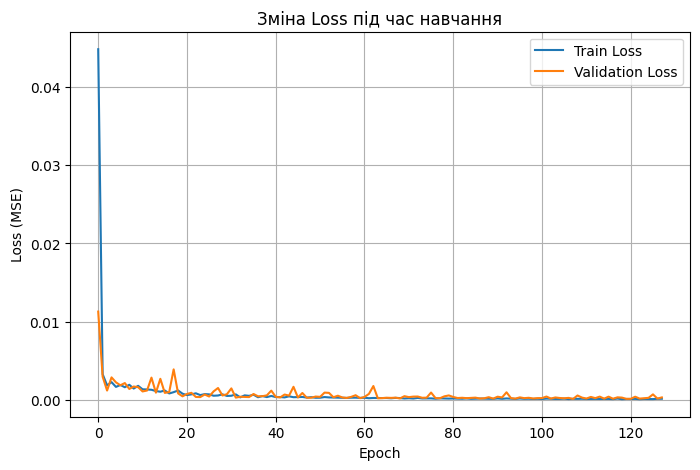

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Навчання
history = model.fit(
    X_train[..., np.newaxis],
    y_train_dict,
    validation_data=(X_val[..., np.newaxis], y_val_dict),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Побудова графіка втрат
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Зміна Loss під час навчання')
plt.legend()
plt.grid(True)
plt.show()

# 5. Оцінка моделі на тестових даних та денормалізація результатів.

141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
B0: MAE = 0.499, MSE = 0.5561
dB: MAE = 2.214, MSE = 8.4275
p: MAE = 0.009, MSE = 0.0004
I: MAE = 0.000, MSE = 0.0000


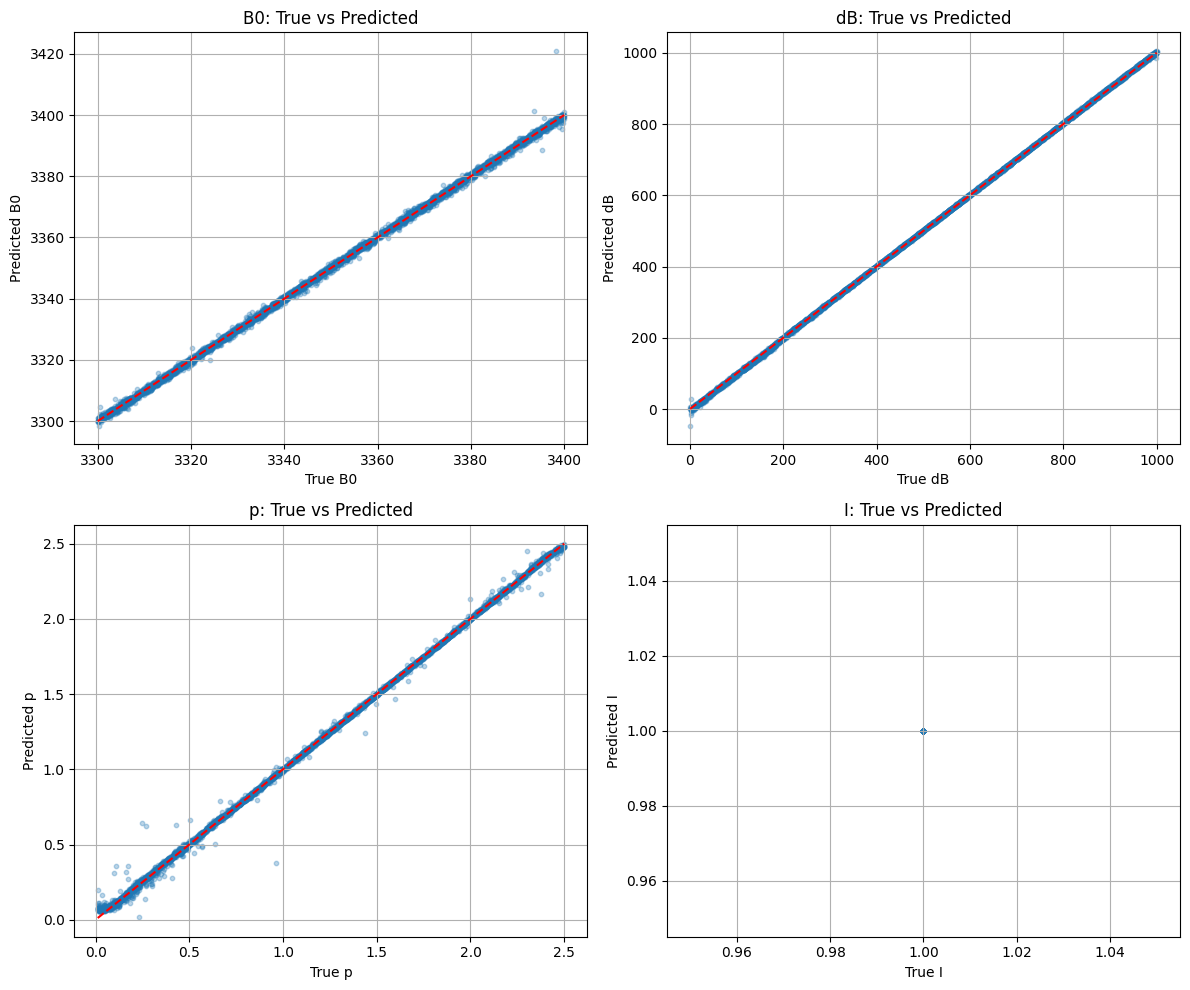

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam


# Завантажуємо модель без компіляції
#model = load_model('best_cnn_model.h5', compile=False)

# Повторно скомпілюємо модель з обʼєктами
#model.compile(
#      optimizer='adam',
#      loss={'B0': 'mse', 'dB': 'mse', 'p': 'mse', 'I': 'mse'},
#      loss_weights={'B0': 1.0, 'dB': 1.0, 'p': 2.0, 'I': 1.0},  # посилення ваги p
#      metrics={'B0': 'mae', 'dB': 'mae', 'p': 'mae', 'I': 'mae'}
#      )
# Передбачення
y_pred_norm = model.predict(X_test[..., np.newaxis])
y_pred_norm = np.concatenate(y_pred_norm, axis=1)  # форма стане (n_samples, 4)

# Денормалізація
y_pred = y_pred_norm * (y_max - y_min) + y_min
y_true = y_test * (y_max - y_min) + y_min

# Обчислення метрик по кожному параметру
param_names = ['B0', 'dB', 'p', 'I']
for i, name in enumerate(param_names):
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    mse = mean_squared_error(y_true[:, i], y_pred[:, i])
    print(f'{name}: MAE = {mae:.3f}, MSE = {mse:.4f}')

# Побудова графіків "істинне vs передбачене"
plt.figure(figsize=(12, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.3, s=10)
    plt.plot([y_true[:, i].min(), y_true[:, i].max()],
             [y_true[:, i].min(), y_true[:, i].max()], 'r--')
    plt.xlabel(f'True {param_names[i]}')
    plt.ylabel(f'Predicted {param_names[i]}')
    plt.title(f'{param_names[i]}: True vs Predicted')
    plt.grid(True)

plt.tight_layout()
plt.show()

# 6. Збереження моделі на Google Disk

In [ ]:
import os
from google.colab import drive

# Перевірка, чи вже підключено Google Drive
if not os.path.ismount('/content/drive'):
    print("🔄 Google Drive не підключено. Підключаємо...")
    drive.mount('/content/drive')
else:
    print("✅ Google Drive вже підключено.")

model.save('/content/drive/MyDrive/Python/DysonianLineCNN-multihead/multihead_cnn_model.h5')
print("Модель збережено в форматі .h5")
#model.save('/content/drive/MyDrive/Python/DysonianLineCNN-multihead/multihead_cnn_model.keras')
#print("Модель збережено в форматі .keras")


✅ Google Drive вже підключено.
Модель збережено в форматі .h5


**Відключення Google Disk**

In [ ]:
import os
from google.colab import drive

# Перевірка, чи вже підключено Google Drive
if os.path.ismount('/content/drive'):
    print("🔄 Google Drive підключено. Відключаємо...")
    drive.flush_and_unmount() # <--- відключити диск
else:
    print("Google Drive не підключено, нема чого відключати.")


🔄 Google Drive підключено. Відключаємо...
